In [34]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import matplotlib.pyplot as plt

In [35]:
df = pd.read_pickle("df.pkl")
print(len(df))
df.head(5)

23530


,year,age,poll_age,num_rated,rating,bayes_rating,owned,attrs,npl_min,npl_max,poll_npl_min,poll_npl_max,dur_min,dur_max
387,2000,10,10.500000,337,5.81844,5.55090,697,"[Card Game, Hand Management, Series, Bluffing]",3,7,3,7,3.806662,3.806662
475,2000,12,11.454545,7149,7.27751,6.93109,8569,"[Series, Bluffing, Auction, Drafting, Card Dra...",2,5,3,5,3.806662,4.499810
478,2000,10,9.898396,49176,7.07999,6.97364,65605,"[Tableau Building, Series, Bluffing, Drafting,...",2,8,2,7,2.995732,4.094345
481,2000,12,10.785714,3429,6.81879,6.38725,3909,"[Team-Based Game, Area Majority / Influence, D...",2,4,2,4,4.094345,4.094345
490,2000,12,10.200000,262,7.70292,5.65154,340,"[Print & Play, Wargame, Dice, Hexagon Grid, My...",2,6,2,6,4.094345,4.094345


In [36]:
class DictEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for xs in X:
            yield { x: 1 for x in xs }

In [51]:
binary_encoder = Pipeline([
    ('encode',   DictEncoder()),
    ('vectorize',DictVectorizer(sparse=False))
])
X_all = Pipeline([
    ('attrs',ColumnTransformer([
        ('attrs',Pipeline([
            ('encode',binary_encoder),
            ('pca',PCA(n_components=64))
        ]),'attrs'),
        ('age','passthrough',[
            'poll_age','poll_npl_min','poll_npl_max','dur_min','dur_max'
        ])
    ]))
]).fit_transform(df)
X_all.shape

(23530, 69)

In [57]:
binary_encoder = Pipeline([
    ('encode',   DictEncoder()),
    ('vectorize',DictVectorizer(sparse=False))
])
X_all = Pipeline([
    ('features',ColumnTransformer([
        ('attrs',Pipeline([
            ('encode',binary_encoder)
        ]),'attrs'),
        ('age','passthrough',[
            'poll_age','poll_npl_min','poll_npl_max','dur_min','dur_max'
        ])
    ])),
    ('pca',PCA(n_components=64))
]).fit_transform(df)
X_all.shape

(23530, 64)

In [58]:
class ScaleRatingByYear(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.m = {
            key: vals for key,*vals in
            X.groupby('year').agg({'rating':['mean','std']}).to_records()
        }
        return self
    def transform(self, X):
        def scale(x):
            mean, std = self.m[x[0]]
            return (x[1]-mean)/std
        return X[['year','rating']].apply(scale,axis=1)

In [59]:
y_all = ScaleRatingByYear().fit_transform(df).to_numpy()

In [60]:
# X_pca = PCA(n_components=64).fit_transform(X_all)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.35, random_state=123)

In [62]:
forest = RandomForestRegressor(n_estimators=1000, max_depth=8, max_features=10, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_features=10, n_estimators=1000,
                      n_jobs=-1)

In [68]:
forest.score(X_train, y_train)

0.5257996554197645

In [64]:
forest.score(X_test, y_test)

0.44695524055623836

In [22]:
forest_gs = GridSearchCV(
    RandomForestRegressor(n_estimators=500, n_jobs=-1),
    { 'max_depth': [2,4,8,12,16],
      'max_features': [8,16,32,64]
    },
    cv=3
).fit(X_train, y_train)

In [24]:
forest_gs.cv_results_

{'mean_fit_time': array([  2.72261453,   5.46263957,  12.16833719,  23.88698268,
          6.13963842,  11.73165536,  23.00575956,  44.94255304,
         10.76656739,  25.2597812 ,  70.89996155, 138.74330266,
         24.84024151,  47.92540836,  94.42621088, 184.51554497,
         29.90930239,  58.14761567, 118.88452506, 228.71328545]),
 'std_fit_time': array([0.24935826, 0.72091849, 0.03786573, 0.04755392, 0.02150349,
        0.03773395, 0.02932196, 0.14009023, 0.01071674, 6.19604828,
        0.30132518, 1.63203191, 0.05091426, 0.11865202, 0.35944977,
        0.91730194, 0.11232006, 0.33859065, 1.67607622, 1.18577965]),
 'mean_score_time': array([0.09714421, 0.06951594, 0.0673209 , 0.0675052 , 0.07917968,
        0.0791537 , 0.08005865, 0.07721814, 0.14738329, 0.14765978,
        0.16722973, 0.1256144 , 0.22342443, 0.19288898, 0.21348214,
        0.18002343, 0.29985944, 0.28812059, 0.2579066 , 0.22595501]),
 'std_score_time': array([0.04470763, 0.00061771, 0.00111072, 0.00114271, 0.00

In [33]:
for i,p in enumerate(forest_gs.cv_results_['params']):
    print(
        p,
        [ forest_gs.cv_results_[f'split{j}_test_score'][i] for j in range(forest_gs.cv) ]
    )

{'max_depth': 2, 'max_features': 8} [0.07770948860309967, 0.07781513618730806, 0.0750705776060051]
{'max_depth': 2, 'max_features': 16} [0.10031645475652762, 0.0978988794869512, 0.09742150428673046]
{'max_depth': 2, 'max_features': 32} [0.12514487033314725, 0.12605691916989803, 0.12232990522737897]
{'max_depth': 2, 'max_features': 64} [0.14343196684780102, 0.14849538239923743, 0.14103404956226007]
{'max_depth': 4, 'max_features': 8} [0.1321568519153804, 0.13619741942475405, 0.13503772623570232]
{'max_depth': 4, 'max_features': 16} [0.1597935360173981, 0.1606070450237035, 0.15674547278953133]
{'max_depth': 4, 'max_features': 32} [0.17662312180225326, 0.18355232068787175, 0.17528477448838786]
{'max_depth': 4, 'max_features': 64} [0.19069768004727272, 0.1956025776156749, 0.18634424379433723]
{'max_depth': 8, 'max_features': 8} [0.2100362534485235, 0.21272244221132575, 0.20542912509342004]
{'max_depth': 8, 'max_features': 16} [0.22551452729256516, 0.228343467109141, 0.21885791569782442]
{'

In [53]:
models = [
    RandomForestRegressor(
        n_estimators=1000, max_depth=x, max_features=10, n_jobs=-1
    ).fit(X_train, y_train)
    for x in range(2,16)
]

train_errors = []
test_errors = []
for model in models:
    train_errors.append(metrics.mean_squared_error(y_train, model.predict(X_train)))
    test_errors.append(metrics.mean_squared_error(y_test, model.predict(X_test)))

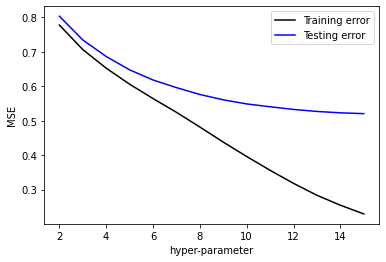

In [55]:
plt.plot(range(2,16), train_errors, 'k-', label='Training error')
plt.plot(range(2,16), test_errors, 'b-', label='Testing error')
plt.xlabel('hyper-parameter')
plt.ylabel('MSE')
plt.legend(loc='upper right')

In [ ]:
class Predictor():
    def __init__(self,pca):
        self.pca = pca